<a href="https://colab.research.google.com/github/tkksnk/macrotopicsA2022/blob/main/Jupyter/quantmacro_chapter2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 北尾早霧・砂川武貴・山田知明『定量的マクロ経済学と数値計算』日本評論社
## 第2章：2期間モデルと数値計算の概観

## 2.4 操作変数を連続変数にする：最適化
* モデルは前回と同じ

### パラメータをまとめた変数(structured variable)を用意する

In [6]:
class Models:
    def __init__(self,β:float,γ:float,rent:float,nw:int,w_max:float,w_min:float,grid_w:"np.ndarray[np.float64]"):
        # パラメータ
        self.β = β # 割引因子
        self.γ = γ # 相対的危険回避度

        # 要素価格
        self.rent = rent # 純利子率

        # グリッド
        self.nw = nw # 所得グリッドの数
        self.w_max = w_max # 所得グリッドの最大値
        self.w_min = w_min # 所得グリッドの最小値 
        self.grid_w = grid_w # 所得グリッド

In [7]:
def Calibration():
    # パラメータはここで設定をする
    β = 0.985**30
    γ = 2.0
    rent = 1.025**30 - 1.0
    nw = 10
    w_max = 1.0
    w_min = 0.1

    grid_w = np.linspace(w_min,w_max,nw)

    return Models(β, γ, rent, nw, w_max, w_min, grid_w)

---

## 経済学でよく使う関数

In [8]:
def CRRA(cons,γ):
    if γ != 1.0:
        return cons**(1.0 - γ) / (1.0 - γ)
    else:
        return np.log(cons)

---

In [9]:
# 使う関数を呼び出す
import numpy as np # 配列を扱うためのパッケージ
import matplotlib.pyplot as plt # プロットを行うためのパッケージ
!pip install japanize_matplotlib
import japanize_matplotlib # プロットで日本語を使うためのパッケージ
from scipy import optimize # Python上の Optimization Tool
import time # 計測時間をはかるためのパッケージ

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Optimizationの中に入れる目的関数を設定
* 一般的に**Optimization Tool**は"解きたい関数"をインプットとして取る
* インプットの順番が大事
    * 最大化したい変数が一番最初の場合が多い：使いたいライブラリによる
* テキストの(2.6)式

In [10]:
def obj_two_period(a,w_val,params):
    """
    所得wを所与として、2期間モデルの生涯効用を返す関数
    @author Tokuma Suzuki(Julia ver)
    
    # インプット
    `a::Real`: 貯蓄水準
    `w_val::Real`: 所得水準
    `m::Models`: パラメータを含む構造体(βとかγ：カリブレーションの場所で設定済み)

    # アウトプット 
    生涯効用:
    """
    # 1期目の効用
    if w_val - a > 0.0:
        util_y = CRRA(w_val - a, params.γ)
    else:
        util_y = -1000000.0 #負の消費に対するペナルティ
    
    # 2期目の割引効用
    util_o = params.β*CRRA((1.0 + params.rent)*a, params.γ)

    # optimizeが最小値を探すので、マイナスをかけることで最適な値を求める。
    return  -1.0*(util_y + util_o)

---

## Tips：モジュールをインストール（未インストールの場合）
* 分析に応じてライブラリを事前にインストールする必要がある
* まだ必要なパッケージがインストールされていない場合、⬇の方法でインストールする必要がある
    * PythonからでもJupyter Notebook経由でも一緒

In [11]:
# インストール済みならスキップ
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## メインのプログラムを走らせる

In [12]:
# 事前に設定しておいたパラメータをparamsという一つの変数にまとめる：struct
params = Calibration()

---

In [13]:
# 空の変数を用意
a_gs = np.zeros(params.nw)
from scipy.optimize import Bounds

Bounds(1,2).lb

array(1)

In [14]:
# 各wについて目的関数を最大にするような貯蓄水準aを求める
for (w_ind,w_val) in enumerate(params.grid_w):
    
    # 関数obj_two_periodを再定義
    # "aのみをargument"とする関数を作る：optimizeの中に入れる関数はパラメータを与えたもとでの関数である必要あり
    obj_two_period1 = lambda a: obj_two_period(a,w_val,params)

    # ブレント法(Brents' method)により計算
    # 使い方：aの最適値を探す範囲を指定→[w_val*0.01, w_val*2.0]
    # この範囲内で関数を最小(最大)にするaを見つけ出すアルゴリズム
    
    res = optimize.fminbound(obj_two_period1,w_val*0.01,w_val*2.0)
    a_gs[w_ind] = res

print(a_gs)

[0.03550017 0.07100035 0.10650385 0.14200403 0.17750421 0.21300505
 0.24850589 0.28400673 0.31950757 0.35500841]


## 計算を高速化するためには関数化したほうが良い(場合が多い)

In [15]:
def optimization(params):
    """
    政策関数を最適化を用いて求める

    # インプット
    `params`:パラメータを含む構造体
    # アウトプット
    `a_gs`政策関数
    """

    a_gs = np.zeros(params.nw)

    # 各wについて目的関数を最大にするような貯蓄水準を求める
    for (w_ind,w_val) in enumerate(params.grid_w):
        
        obj_two_period1 = lambda a: obj_two_period(a,w_val,params)

        # ブレント法(Brents' method)により計算
        res = optimize.fminbound(obj_two_period1,w_val*0.01,w_val*2.0)
        
        a_gs[w_ind] = res
    
    return a_gs

In [16]:
# 関数の実行
start = time.time() # 実行時間の計測開始
a_gs = optimization(params)
end = time.time() # 実行時間の計測終了

print(f"{end-start:.6f} seconds")
print(a_gs)

0.008084 seconds
[0.03550017 0.07100035 0.10650385 0.14200403 0.17750421 0.21300505
 0.24850589 0.28400673 0.31950757 0.35500841]


---

## 結果を出力

In [17]:
# 解析解：(2.4)式
coef1 = (params.β*(1.0 + params.rent))**(-1.0/params.γ)
coef2 = 1.0/(1.0+coef1*(1.0 + params.rent))
a_cfs = coef2*params.grid_w

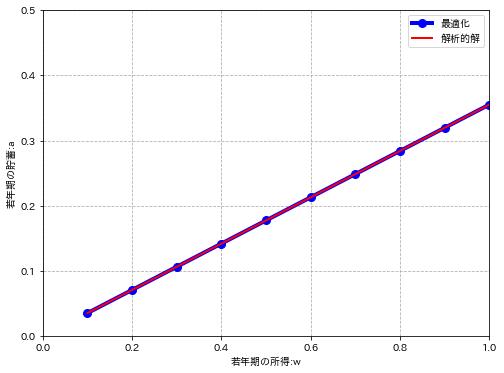

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.grid_w,a_gs,c="b",marker="o",lw=4,ms=8,label="最適化")
ax.plot(params.grid_w,a_cfs,c="r",lw=2,label="解析的解")
ax.set(xlabel="若年期の所得:w",ylabel="若年期の貯蓄:a",xlim=(0,1.0),ylim=(0,0.5))
ax.legend(loc="upper right")
ax.grid(ls="--")
plt.show()

---

## エクササイズ
* グリッドサイズを変更して、計算時間がどの程度変わるのかを確認してみよう
* 前節で学習した操作変数を離散化する場合と比較して、計算時間がどの程度変わるのかを確認してみよう。